<a href="https://colab.research.google.com/github/behdad13/time-series-forecasting/blob/main/LSTM_AE_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## importing necessary libraries 

In [1]:
#installing necessary libraries
!pip install torch
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 10.6 MB/s 
     |████████████████████████████████| 210 kB 30.9 MB/s 
     |████████████████████████████████| 81 kB 11.8 MB/s 
     |████████████████████████████████| 78 kB 9.3 MB/s 
     |████████████████████████████████| 50 kB 9.4 MB/s 
     |████████████████████████████████| 147 kB 31.3 MB/s 
     |████████████████████████████████| 112 kB 34.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=542583f7118b2ac6360a20da6e5bec87f79efe912a9b09953a118958f01cfd27
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Unin

In [2]:
#import necessary libraries
import os
import random
import time
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy import array
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.trial import TrialState
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.nn.functional as F
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [11]:
#set seed
seed_val = 67
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## importing pre-processed dataset

In [12]:
#import the dataset
data = pd.read_csv('Data_Toronto.csv', low_memory=False)

#select the most relevent feature from the dataset
data = data[['Year', 'Month', 'Day', 'Hour', 'week_end','temperature', 'humidex', 'Ontario_Real_price', 'Electricity_Load']]

In [13]:
#define the test and train set
seq = 5*24
horizon = 24
train = data.iloc[17520+8760+8786 - seq : 43824 + horizon]
test = data.iloc[43824 - seq : 43824+30*24 + horizon]

## train-val-test split

In [14]:
#defining the training proportion
#seperating train and validation set
train_size = int(len(data)*0.80)      
valid_size = int(len(data)*0.20)
df_train, df_val = data[:train_size], data[train_size+1:]
df_train.shape, df_val.shape, test.shape

((38534, 9), (9633, 9), (864, 9))

In [15]:
# scaling each features of the dataset
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train),index = df_train.index, columns = df_train.columns)
df_val = pd.DataFrame(scaler.transform(df_val),index = df_val.index, columns = df_val.columns)
test = pd.DataFrame(scaler.transform(test),index = test.index, columns = test.columns)

## Make a time sequneces

In [16]:
df_train = df_train.to_numpy()
df_val = df_val.to_numpy()
test = test.to_numpy()

In [17]:
# split a multivariate sequence into samples
from numpy import array
def split_sequences(sequences, n_steps, for_hor):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-for_hor:
            break
        # gather input and output parts of the pattern
        # sequence_x ranges from 0 to seq_len and all columns except the last one.
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:end_ix+for_hor, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [18]:
n_timesteps = 24*5
for_hor = 24
X_train, y_train = split_sequences(df_train, n_timesteps, for_hor)
X_val, y_val = split_sequences(df_val, n_timesteps, for_hor)
X_test, y_test = split_sequences(test, n_timesteps, for_hor)

In [19]:
print(X_test.shape, y_test.shape)

(721, 120, 9) (721, 24)


In [20]:
n_timesteps + len(X_train) + for_hor-1 == len(df_train)

True

 ## Data Loader

In [21]:
from torch.utils.data import TensorDataset, DataLoader
import torch

batch_size = 64


X_train_t = torch.Tensor(X_train)
y_train_t = torch.Tensor(y_train)
X_val_t = torch.Tensor(X_val)
y_val_t = torch.Tensor(y_val)
X_test_t = torch.Tensor(X_test)
y_test_t = torch.Tensor(y_test)

train = TensorDataset(X_train_t, y_train_t)
val = TensorDataset(X_val_t, y_val_t)
test_w1 = TensorDataset(X_test_t, y_test_t)


train_loader = DataLoader(train, batch_size=batch_size, shuffle = True, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle = False, drop_last=True)
test_loader_one_w1 = DataLoader(test_w1, batch_size=1, shuffle = False, drop_last=True)

In [22]:
#check the size of the train set
X_train_t.shape, y_train_t.shape

(torch.Size([38391, 120, 9]), torch.Size([38391, 24]))

In [23]:
#just for testing the size of the batch
next(iter(train_loader))[1].size(), next(iter(train_loader))[0].size()

(torch.Size([64, 24]), torch.Size([64, 120, 9]))

## deep learning model

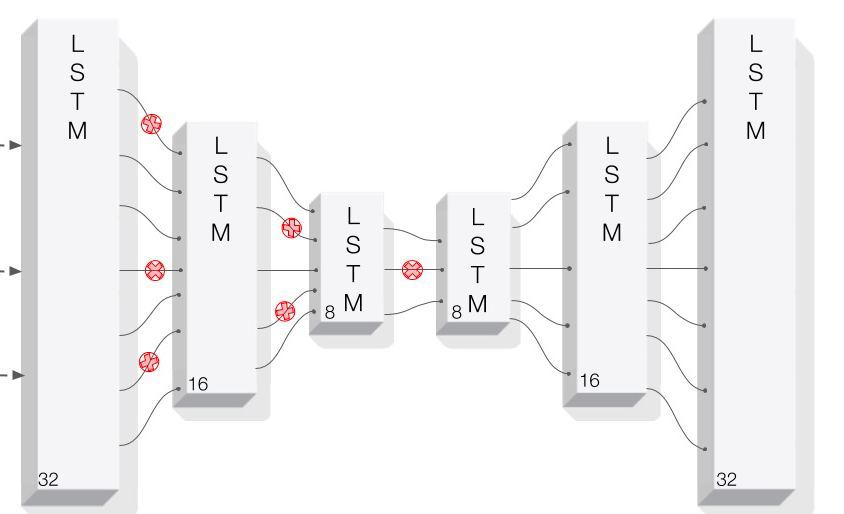

In [24]:
class LSTMAE(nn.Module):
    def __init__(self, input_size, hidden_size, output_dim, seq_len):
        super(LSTMAE, self).__init__()
        self.seq_len = seq_len
   
        self.lstm_enc_1 = nn.LSTM(     #the first LSTM encoder layer 
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True)
        
        self.lstm_enc_2 = nn.LSTM(     #the second LSTM encoder layer
            input_size=hidden_size,
            hidden_size=hidden_size//2,
            batch_first=True)

        self.lstm_enc_3 = nn.LSTM(     #the third LSTM encoder layer
            input_size=hidden_size//2,
            hidden_size=hidden_size//4,
            batch_first=True)
        
        self.lstm_dec_1 = nn.LSTM(     #the first LSTM decoder layer
            input_size=hidden_size//4,
            hidden_size=hidden_size//4,
            batch_first=True)
            
        self.lstm_dec_2 = nn.LSTM(     #the second LSTM decoder layer
            input_size=hidden_size//4,
            hidden_size=hidden_size//2,
            batch_first=True)
        
        self.lstm_dec_3 = nn.LSTM(     #the third LSTM decoder layer
            input_size=hidden_size//2,
            hidden_size=hidden_size,
            batch_first=True)
            
        self.fc1 = nn.Linear(hidden_size*seq_len, output_dim) 

    def forward(self, x):
        x, (h_n, c_n) = self.lstm_enc_1(x)       #encoder section
        x, (h_n, c_n) = self.lstm_enc_2(x)
        x, (h_n, c_n) = self.lstm_enc_3(x)
        h_n=h_n.repeat(self.seq_len, 1, 1)
        h_n=h_n.permute(1,0,2)
        x, (h_n, c_n) = self.lstm_dec_1(h_n)     #decoder section
        x, (h_n, c_n) = self.lstm_dec_2(x)
        x, (h_n, c_n) = self.lstm_dec_3(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)

        return x

In [25]:
#checking dimensions of the lstm-ae layers
x = torch.rand(64, 120, 9)
model = LSTMAE(input_size=9, hidden_size=64, output_dim=24, seq_len=120)

y = model(x)
y.shape

torch.Size([64, 24])

In [29]:
#defining an objective function of the bayesian Optimization and which parameters need to be tuned
epochs = 250 
patience = 20
loss = nn.MSELoss()
min_val_loss_total=np.inf

def objective(trial):
    #define the infinity variable
    min_val_loss = np.inf
    
    # Generate the model.
    model = LSTMAE(input_size=9,
                   hidden_size=trial.suggest_int("hidden_size", 64, 256),
                   output_dim=24, 
                   seq_len=120).cuda()

    # Generate the optimizers.
    loss_fn = nn.MSELoss() 
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # Training of the model.
    counter = 0
    for i in range(epochs):
        mse_train = 0
        iteration_start = time.monotonic()
        for batch_x, batch_y in train_loader :
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            opt.zero_grad()
            y_pred = model(batch_x)
            y_pred = y_pred.squeeze(1)
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()
        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
                output = model(batch_x)
                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
        preds = np.concatenate(preds)
        true = np.concatenate(true)

        if min_val_loss > mse_val:
            min_val_loss = mse_val
            counter = 0
        else: 
            counter += 1
        if counter == patience:
            break   

        global min_val_loss_total
        if min_val_loss_total > mse_val:
            min_val_loss_total = mse_val
            torch.save(model.state_dict(), "LSTMAE_BO.pt")

        if i % 20 == 0:
            print("Iter: ", i, "train: ", (mse_train), "val: ", (mse_val))
        
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        trial.report(min_val_loss, i)
        
    return min_val_loss

In [31]:
if __name__ == "__main__":
    #create the study
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

    #calling the optimzation process
    study.optimize(objective, n_trials=5)  

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-27 18:13:11,906] A new study created in memory with name: no-name-20e06e2d-e00f-4fa7-bffd-4a6e619c463d


Iter:  0 train:  376.7527498751879 val:  33.82815605774522
Iter:  20 train:  21.99916822463274 val:  36.44895707629621


[I 2022-12-27 18:22:28,532] Trial 0 finished with value: 24.41965035907924 and parameters: {'hidden_size': 250, 'lr': 0.0007987750114939934}. Best is trial 0 with value: 24.41965035907924.


Iter:  0 train:  1053.5677579641342 val:  243.76609700918198
Iter:  20 train:  115.07136964052916 val:  36.15180943533778
Iter:  40 train:  97.89787025004625 val:  31.89484351873398
Iter:  60 train:  84.49341589957476 val:  29.317639365792274
Iter:  80 train:  76.83389662951231 val:  29.91097866743803
Iter:  100 train:  72.60959578305483 val:  26.863252460956573
Iter:  120 train:  69.6379801183939 val:  27.762181397527456
Iter:  140 train:  67.72162253409624 val:  25.708040995523334


[I 2022-12-27 18:36:51,549] Trial 1 finished with value: 24.924460304901004 and parameters: {'hidden_size': 67, 'lr': 2.9375155042774672e-05}. Best is trial 0 with value: 24.41965035907924.


Iter:  0 train:  505.4346996843815 val:  43.094174191355705
Iter:  20 train:  41.22115211188793 val:  38.399033011868596


[I 2022-12-27 18:46:45,748] Trial 2 finished with value: 24.94503060914576 and parameters: {'hidden_size': 146, 'lr': 0.0005097385198030268}. Best is trial 0 with value: 24.41965035907924.


Iter:  0 train:  514.601529404521 val:  38.12467809021473
Iter:  20 train:  36.70027181506157 val:  34.64023766480386


[I 2022-12-27 18:57:10,208] Trial 3 finished with value: 23.146845733746886 and parameters: {'hidden_size': 150, 'lr': 0.0005637290910352976}. Best is trial 3 with value: 23.146845733746886.


Iter:  0 train:  395.40773087739944 val:  37.10736448317766
Iter:  20 train:  30.017998909577727 val:  36.73885810188949


[I 2022-12-27 19:05:41,550] Trial 4 finished with value: 23.586791668087244 and parameters: {'hidden_size': 221, 'lr': 0.0005986114545546242}. Best is trial 3 with value: 23.146845733746886.


Study statistics: 
  Number of finished trials:  5
  Number of pruned trials:  0
  Number of complete trials:  5
Best trial:
  Value:  23.146845733746886
  Params: 
    hidden_size: 150
    lr: 0.0005637290910352976


<ipython-input-33-a3e6d362e88b>:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["hidden_size", "lr" ])


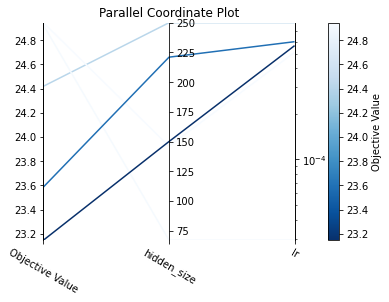

In [33]:
#Visualizing sets of tunned yperparameters based on the BO
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["hidden_size", "lr" ])
optuna.visualization.plot_param_importances(study)

In [ ]:
#Download the PT file
from google.colab import files
files.download('LSTMAE_BO.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
#Read the pk file
model = LSTMAE(input_size=9,
                   hidden_size=150,
                   output_dim=24, 
                   seq_len=120).cuda()

model.load_state_dict(torch.load("LSTMAE_BO.pt"))

<All keys matched successfully>

In [35]:
#call a desacaler function for the further analysis
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [36]:
# the error calculation function
def calculate_metrics(values_descaled, prediction_descaled):
    result_metrics = {
                      'MAE' : mean_absolute_error(values_descaled, prediction_descaled),
                      'MSE' : mean_squared_error(values_descaled, prediction_descaled),
                      'R2'  : r2_score(values_descaled, prediction_descaled),
                      'MAPE': mean_absolute_percentage_error(values_descaled, prediction_descaled)
                      }
    print("Root Mean Squared Error :  ", result_metrics["MSE"]**0.5)
    print("R^2                :       ", result_metrics["R2"])
    print("Mean Absolute Error:       ", result_metrics["MAE"])
    print("MAPE               :       ", result_metrics["MAPE"])
    
    return result_metrics

Test set results

In [37]:
# feeding the model with the test set.
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y in test_loader_one_w1:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
preds = np.concatenate(preds)
true = np.concatenate(true)

Illustration of one-step, two-step, three-step, and 24-step ahead forecasting

error for next 1 hour prediction
Root Mean Squared Error :   193.52220623559023
R^2                :        0.9211355225415411
Mean Absolute Error:        159.35734162350468
MAPE               :        0.02697107193073305


error for next 2 hour prediction
Root Mean Squared Error :   175.50544786396958
R^2                :        0.934998833099802
Mean Absolute Error:        140.6467501869149
MAPE               :        0.02358129379002244


error for next 3 hour prediction
Root Mean Squared Error :   173.19843593720913
R^2                :        0.9389591671386417
Mean Absolute Error:        139.6489826683859
MAPE               :        0.023452927016920665


error for next 24 hour prediction
Root Mean Squared Error :   317.75278463457727
R^2                :        0.7433014081552751
Mean Absolute Error:        253.7682306339936
MAPE               :        0.0432243531702525


1-step ahead forecast
2-step ahead forecast
3-step ahead forecast
24-step ahead forecast


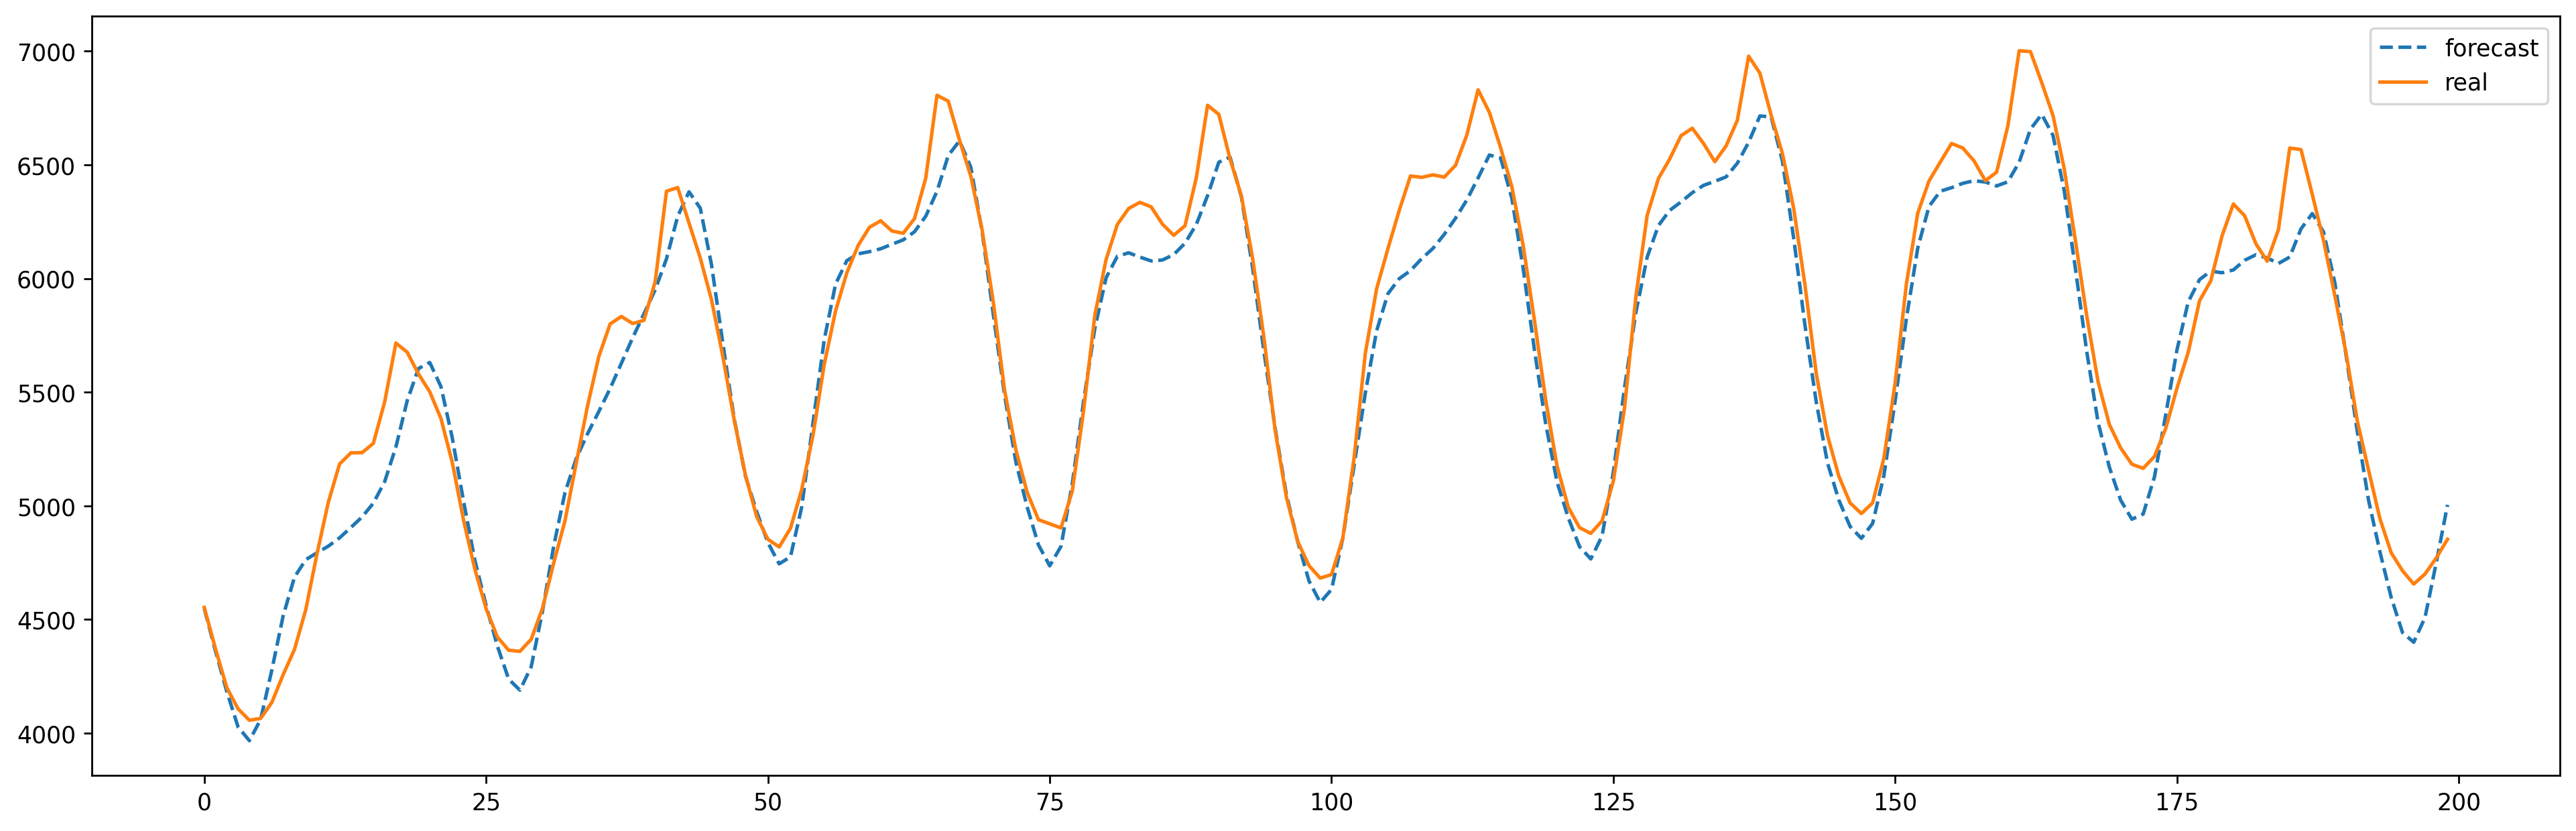

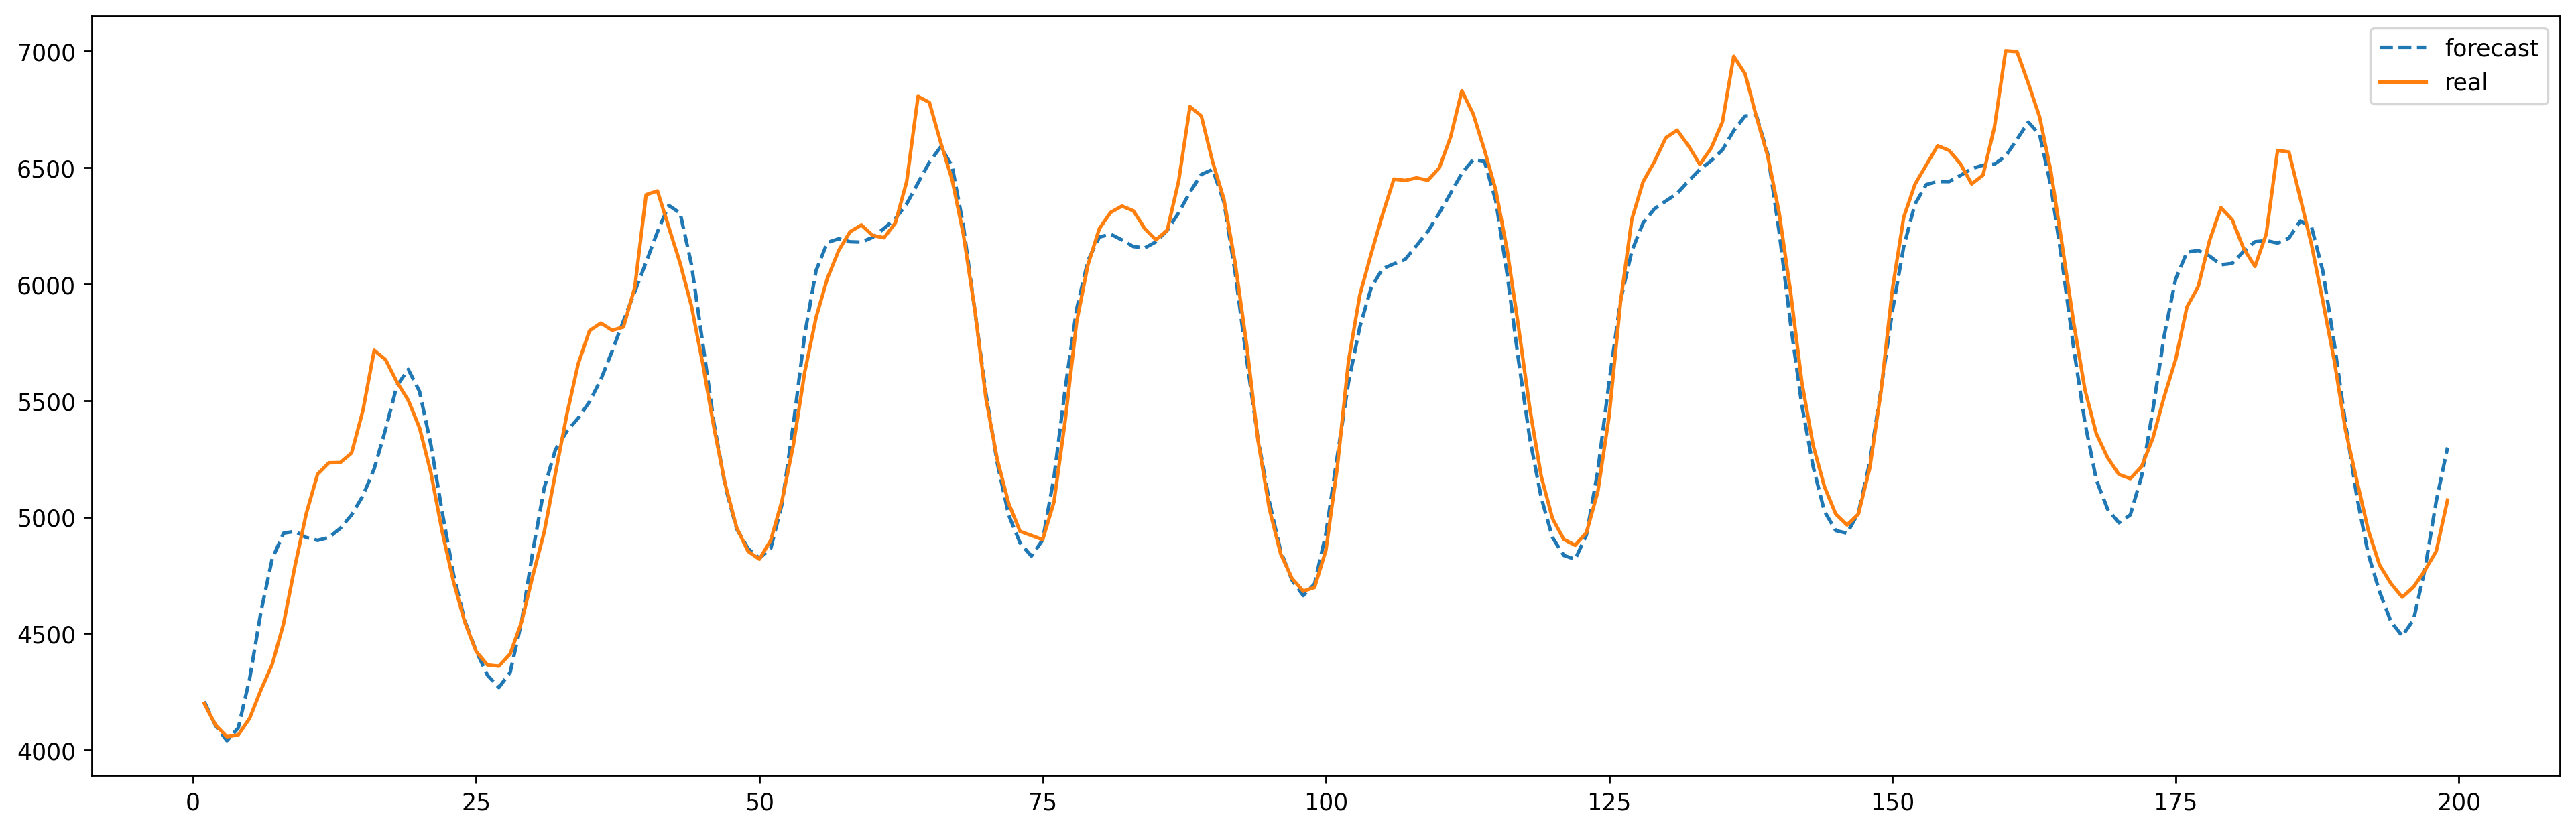

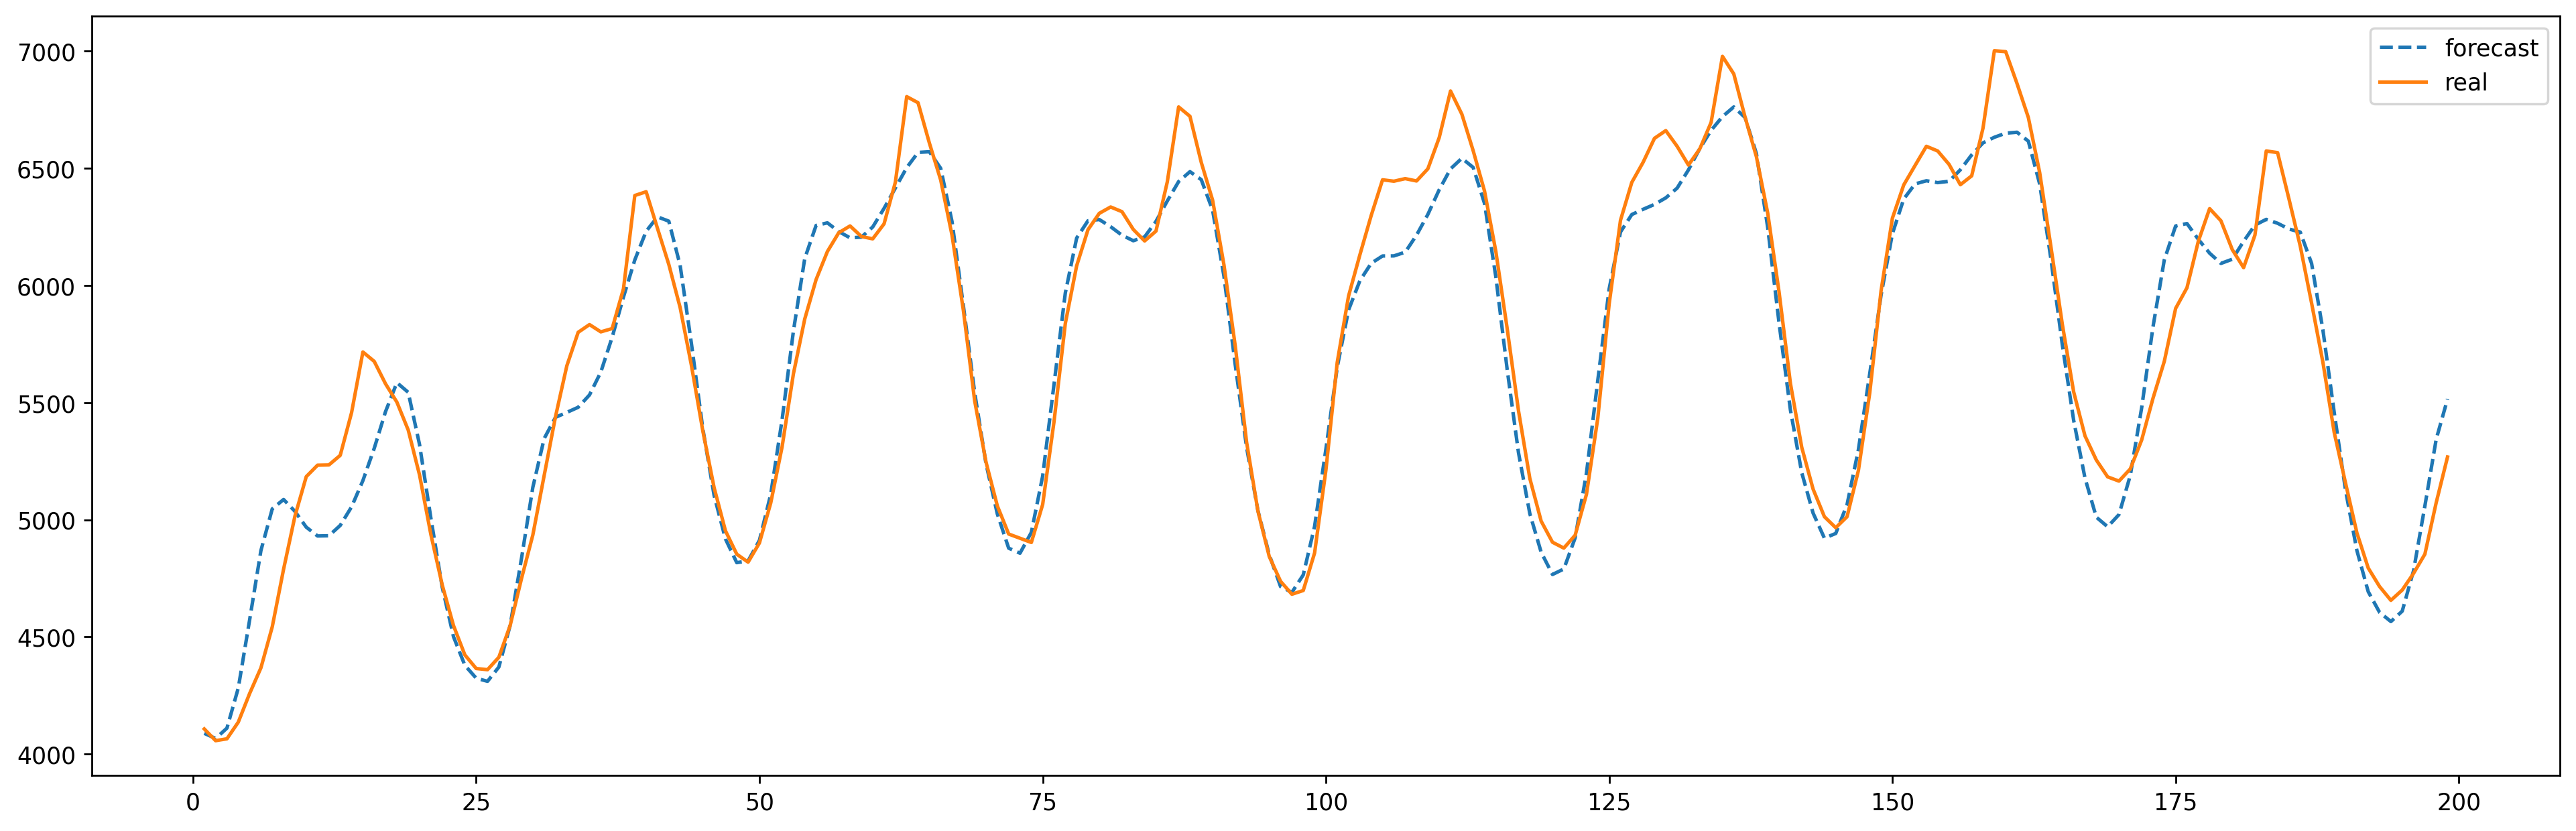

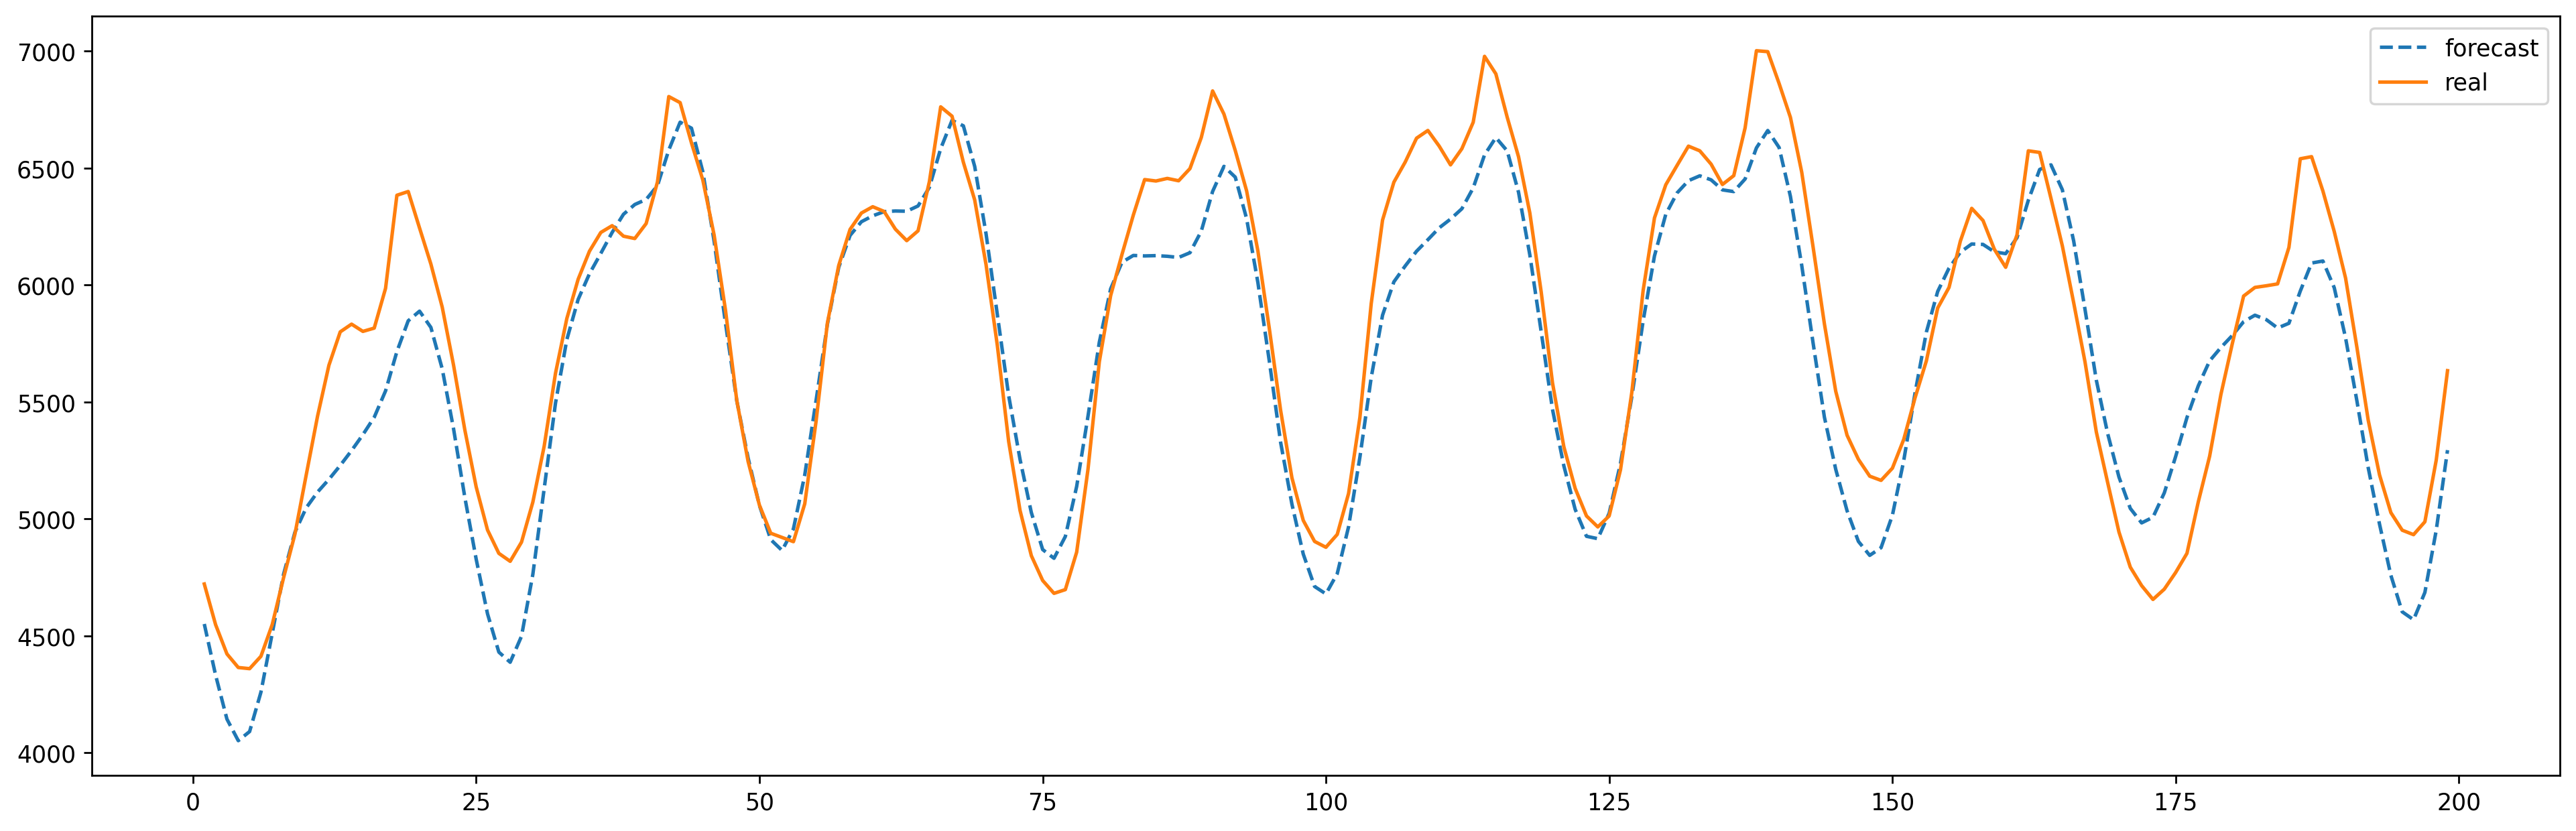

In [38]:
# create an empty dataframe  
df = pd.DataFrame()
df['forcasted_demand_1h'] = 0
df['forcasted_demand_2h'] = 0
df['forcasted_demand_3h'] = 0
df['forcasted_demand_24h'] = 0
df['real_demand_1h'] = 0
df['real_demand_2h'] = 0
df['real_demand_3h'] = 0
df['real_demand_24h'] = 0

for i in range(len(preds)):
    prediction_descaled=[]
    values_descaled=[]
    prediction_descaled = descale(descaler, preds[[i]].reshape(-1))
    values_descaled = descale(descaler, true[[i]].reshape(-1))
    new_row = {'forcasted_demand_1h':prediction_descaled[0], 
           'forcasted_demand_2h':prediction_descaled[1], 
           'forcasted_demand_3h':prediction_descaled[2],
           'forcasted_demand_24h':prediction_descaled[23],
           'real_demand_1h' : values_descaled[0],
           'real_demand_2h' : values_descaled[1],
           'real_demand_3h' : values_descaled[2],
           'real_demand_24h' : values_descaled[23]}
    
    df = df.append(new_row, ignore_index=True)

print('error for next 1 hour prediction')
error_1h = calculate_metrics(df.forcasted_demand_1h,df.real_demand_1h )
print("\n")
print('error for next 2 hour prediction')
error_2h = calculate_metrics(df.forcasted_demand_2h,df.real_demand_2h )
print("\n")
print('error for next 3 hour prediction')
error_3h = calculate_metrics(df.forcasted_demand_3h,df.real_demand_3h )
print("\n")
print('error for next 24 hour prediction')
error_24h = calculate_metrics(df.forcasted_demand_24h,df.real_demand_24h )
print("\n")



print('1-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[0:200], df.forcasted_demand_1h[0:200], "--", label="forecast")
plt.plot(dates[0:200], df.real_demand_1h[0:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('2-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[1:200], df.forcasted_demand_2h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_2h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('3-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_3h))
plt.plot(dates[1:200], df.forcasted_demand_3h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_3h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();


print('24-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_24h))
plt.plot(dates[1:200], df.forcasted_demand_24h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_24h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

Visualizing the seires (the next 24-hour forecast)

In [39]:
prediction_descaled=[]
values_descaled=[]
for i in range(len(preds)):
    prediction_descaled.append(descale(descaler, preds[[i]].reshape(-1)))
    values_descaled.append(descale(descaler, true[[i]].reshape(-1)))

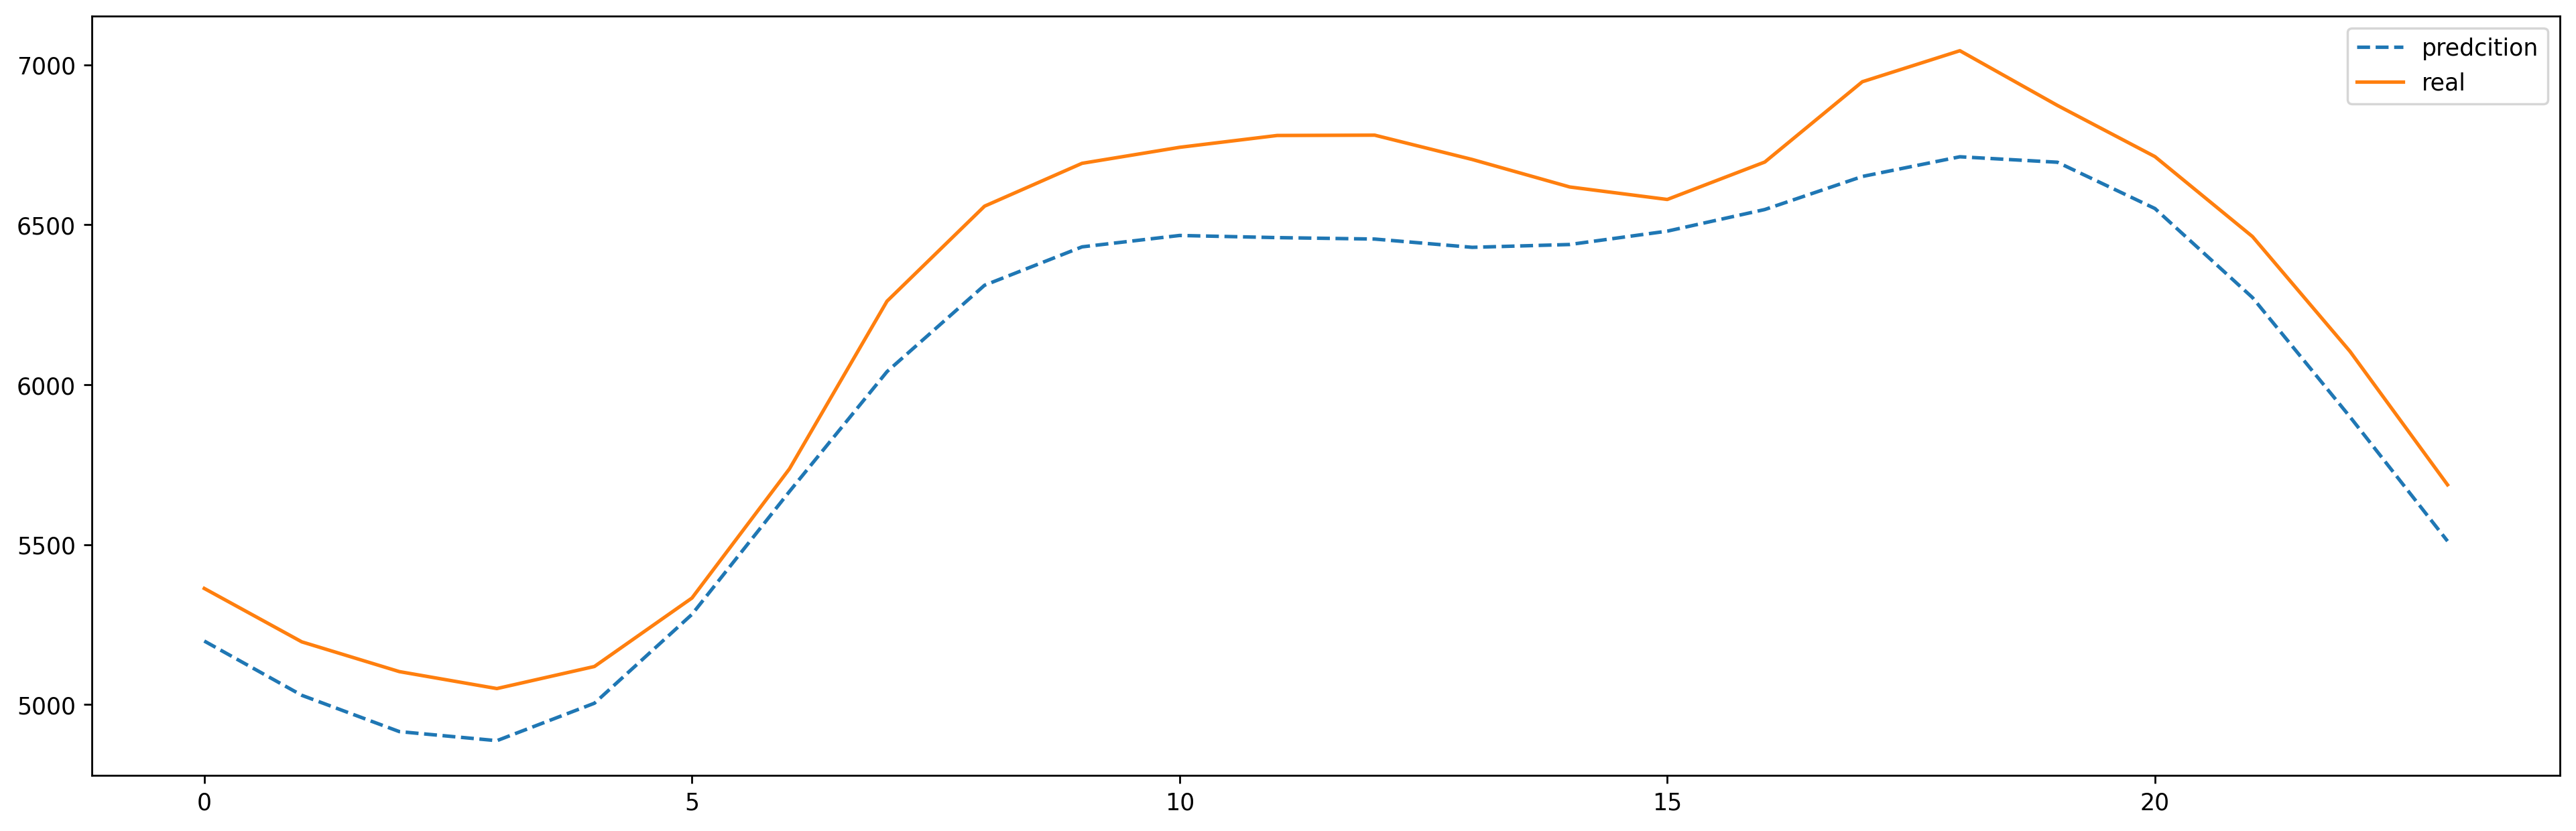

In [40]:
figure(figsize=(19, 6), dpi=250)

j=30*24
dates = range(len(prediction_descaled[j]))
plt.plot(dates[0:24], prediction_descaled[j] , "--", label="predcition")
plt.plot(dates[0:24], values_descaled[j], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();
